## Comparisons of models

In this notebook, we compare the different iterations of the models - MOTES Corpus Model Full as well as the models trained on the subcorpora.

There's a very specific distinction to the analysis here: which is that we're studying trained models rather than text frequencies as a way to better understand how language in a corpus is *used*. We think this 'model as lens to the original corpus' approach is under-done in text analysis, and gives a more nuanced take of word use at large.

The technique for comparing language use between word embedding models that is applied here is based on:

 > *Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora*
    Hila Gonen, Ganesh Jawahar, Djamé Seddah, Yoav Goldberg https://www.aclweb.org/anthology/2020.acl-main.51/
    
They use an nearest neighbour word approach to identify the words that change the most.

__Intersection@k__ - for measuring stability:

- $intersection@k(r_1,r_2) = \frac{|r^k_1 \cap r^k_1|}{k}$

__Usage Change measure__

This uses an overlap between top $k$ words.

- $score^{k}(w) = -|NN^{k}_{1}(w) \cap NN^{k}_{2}(w)|$

Where $NN^{k}_{i}(w)$ is the set of k-nearest neighbors of word $w$ in space $i$. Authors use a value of $k=1000$.

As in Gonen et al, we exclude most frequent words from the analysis, based on usage. 

In [128]:
%load_ext autoreload
%autoreload 2
from compare_tools.configuration import wem_loader # a utility for changing my root dir when using gensim.api
from motes_corpus import modeling
import spacy
import matplotlib.pyplot as plt
import numpy as np
import glob
from IPython.display import display_html
from scipy import sparse
from gensim.corpora import dictionary
import pandas as pd
plt.style.use('seaborn-bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
with open('../data/all_weighted_1_model_include_vocab.txt', mode='r') as f:
    vocab_include_list = f.read().strip().split('\n')
    vocab_include_list = [x for x in vocab_include_list if modeling.word_stopping(x)]
    vocab_include_list = [x for x in vocab_include_list if len(x) > 2]

# just to measure - 
names = pd.read_csv('../data/baby_names.csv').name.str.lower()
vocab_list_wo_names = list(set(vocab_include_list).difference(names))
len(vocab_include_list), len(vocab_list_wo_names)

(27228, 23170)

## Full Model compared to EN Wiki

In [130]:
from gensim.models import KeyedVectors
target_model_path = '/data/motes/models/all_weighted_10-12_100k.kv'
target = KeyedVectors.load(target_model_path)

Common words with a very low-intersect score. This is where the usage in children's corpora diverges from general corpora.

In [6]:
mc = modeling.ModelCompare('/data/motes/models/all_weighted_10-12_100k.kv',
                  '/data/motes/models/enwiki_full_100k.kv',
                  include_list=vocab_include_list)
scores = mc.scores(break_at=10000)
scores.sort_values().head(20)

watchdog            0.022
skipper             0.027
lately              0.036
birdie              0.041
affirmative         0.042
corrections         0.044
ree                 0.052
bucks               0.055
correction          0.058
ing                 0.058
responsibilities    0.061
corrected           0.063
mah                 0.072
soared              0.073
newt                0.074
slaying             0.074
specter             0.076
slump               0.076
spinner             0.077
plo                 0.077
dtype: float64

Words with a very low-intersect score, allowing less common words. This is what is presented in the paper.

In [131]:
scores = mc.scores(break_at=100000)
scores.iloc[:10000].sort_values().head(20)

bucks               0.021
lula                0.029
responsibilities    0.032
nah                 0.033
affirmative         0.035
skipper             0.036
corrections         0.037
yah                 0.038
umbrella            0.046
watchdog            0.047
booming             0.047
sparks              0.049
birdie              0.050
ing                 0.050
tally               0.050
sec                 0.055
woo                 0.061
fortunately         0.062
specter             0.063
pose                0.064
dtype: float64

This is the distribution of intersect scores.

/tmp/ipykernel_21656/698159517.py:15: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  l.append(sorted_scores.index[n])


<AxesSubplot:ylabel='Nearest Neighbor Intersect Score'>

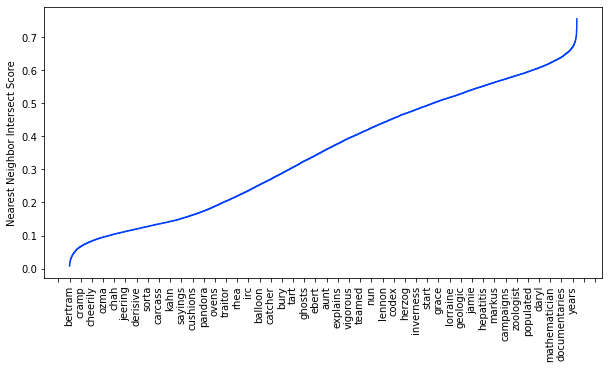

In [8]:
sorted_scores = scores.sort_values()
fig = plt.figure(figsize=(10,5))
ax = sorted_scores.plot(rot=90)
ax.set_ylabel('Nearest Neighbor Intersect Score')
start, end = ax.get_xlim()
step_size = 600


r = np.arange(-step_size, end, step_size)
l = []
for n in r:
    if (n < 0) or (n > len(sorted_scores)):
        l.append('')
    else:
        l.append(sorted_scores.index[n])

ax.xaxis.set_ticks(r)
ax.set_xticklabels(l)
ax

### Looking closer

*How* do these words differ between corpora?

In [133]:
a = scores.iloc[:10000].sort_values(ascending=True)
qs = a[a < .1].head(10).index.tolist()
tab = mc.compare_nns_display_table(qs, 10)
html = tab.to_html().replace("\\n","<br>")
display_html(html, raw=True)

,Nearest Neighbours
word,
bucks,"GENERAL: milwaukee, colts, braves, browns, knicks, phillies, royals, northampton, suns, bullsCHILD: dollars, cents, owe, worth, apiece, pay, thousand, pounds, paid, ticketsOVERLAPS: -"
lula,"GENERAL: silva, joaquim, filho, santos, campos, ernesto, estrada, presidente, joãoCHILD: vasco, rabid, tucked, woke, megahertz, dicey, crept, mum, abbyOVERLAPS: luiz"
responsibilities,"GENERAL: ska, outta, rancid, pavement, shakin, clamped, indie, merrily, sewn, punkCHILD: deodorant, nacho, visa, telltale, sinker, sufferings, muffler, shipmates, aline, amiablyOVERLAPS: -"
nah,"GENERAL: suki, bashful, darned, tickle, piss, groaned, stinker, ceaseless, bleep, ploppedCHILD: seriously, think, improvise, got, heck, know, starving, sticking, disgusting, messedOVERLAPS: -"
affirmative,"GENERAL: nudity, discrimination, fairness, imperative, liar, questionable, abort, prejudice, proposition, hibernationCHILD: ruff, evasive, overload, lint, haw, activate, override, sensors, donatello, homingOVERLAPS: -"
skipper,"GENERAL: mcnair, bully, appleton, jewels, backstory, rhymes, wingspan, melinda, ruff, budsCHILD: kowalski, marlene, miko, rico, mort, suppose, launchpad, sto, abort, napOVERLAPS: -"
corrections,"GENERAL: prisons, inmates, facility, department, prison, detention, rehabilitation, penitentiary, jailCHILD: sync, font, zooming, corrected, barred, waller, reef, rubens, afiOVERLAPS: correction"
yah,"GENERAL: casks, caboose, passageway, baffled, dominator, knapsack, cundinamarca, muffins, jolting, zillionCHILD: hoo, ahh, boo, aah, hee, hah, grunting, woo, ouch, hurtsOVERLAPS: -"
umbrella,"GENERAL: organizations, organisation, organization, organisations, collective, associations, governmental, affiliated, unite, militantCHILD: dope, swaying, kraken, davie, quail, astounded, fetched, soapy, rushes, pluckedOVERLAPS: -"


In [134]:
tab = mc.compare_nns_display_table(['bucks', 'lula', 'affirmative', 'batch', 'bust',
                                    'fantastic', 'anxious', 'foul', 'cool'], 15)
html= tab.to_html().replace('\\n', '<br>')
display_html(html, raw=True)

,Nearest Neighbours
word,
bucks,"GENERAL: milwaukee, colts, braves, browns, knicks, phillies, royals, northampton, suns, bulls, panthers, ers, pittsburgh, akron, bruinsCHILD: dollars, cents, owe, worth, apiece, pay, thousand, pounds, paid, tickets, ransom, allowance, wad, seventy, costingOVERLAPS: -"
lula,"GENERAL: silva, joaquim, filho, santos, campos, ernesto, estrada, presidente, joão, augusto, pinto, vargas, paulo, justoCHILD: vasco, rabid, tucked, woke, megahertz, dicey, crept, mum, abby, grumble, silky, bjorn, butterflies, shovelingOVERLAPS: luiz"
affirmative,"GENERAL: nudity, discrimination, fairness, imperative, liar, questionable, abort, prejudice, proposition, hibernation, arguing, begs, denial, unfair, advocatesCHILD: ruff, evasive, overload, lint, haw, activate, override, sensors, donatello, homing, ominous, detected, awaiting, shashi, watchtowerOVERLAPS: -"
batch,"GENERAL: prototypes, deliveries, shipped, prototype, stored, locomotives, initial, processing, process, commence, ready, delivered, assembling, manually, configurationCHILD: buttered, chocolate, cookies, sliced, potatoes, bacon, decided, dropped, butter, toast, chips, moustache, fertilizer, biscuits, scentedOVERLAPS: -"
bust,"GENERAL: statue, marble, mural, sculpture, portrait, plaque, erected, monumental, louvre, unveiled, engraved, sculptor, monument, bronzeCHILD: doors, stall, perched, shake, upside, swinging, ought, handle, lights, booty, blow, enjoying, swell, rumpOVERLAPS: statues"
fantastic,"GENERAL: marvel, avengers, kirby, strange, hulk, weird, mister, stan, spider, superhero, warlock, beastsCHILD: wonderful, look, happen, great, awesome, let, exciting, swell, friends, job, surprising, seeingOVERLAPS: amazing, incredible, superheroes"
anxious,"GENERAL: uncomfortable, frustrated, unhappy, eager, impatient, preoccupied, wanting, worried, compelled, unwilling, admire, confident, hopeless, distressed, embarrassedCHILD: scarcely, exclaimed, gravely, puzzled, hastily, impatiently, remarked, glance, uneasy, evidently, inquired, accustomed, nearer, replied, feelingOVERLAPS: -"
foul,"GENERAL: batter, touching, outfield, throws, thrown, throw, bounced, touches, hitting, kick, throwing, balls, referee, intentionallyCHILD: odor, utterly, suppose, deny, commands, poking, toss, happily, bite, cursed, dare, beasts, upside, pluckedOVERLAPS: ball"
cool,"GENERAL: warm, winters, summers, humid, mild, damp, hot, sunny, rainy, wet, cold, climates, temperatures, cooler, warmerCHILD: awesome, yeah, guys, looks, pretty, wow, nice, guess, sure, fun, mean, huh, guy, funny, actuallyOVERLAPS: -"


## Sub-corpora

### Youtube

In [11]:
mc = modeling.ModelCompare('/data/motes/models/yt_w_en_100k.kv',
                  '/data/motes/models/enwiki_317k_100k.kv',
                  include_list=vocab_include_list)
yt_scores = mc.scores(break_at=10000)

In [12]:
yt_scores_cleaned = yt_scores[~yt_scores.index.isin(names[:5000])].iloc[:10000].sort_values(ascending=True)
html = mc.compare_nns_display_table(yt_scores_cleaned.iloc[:10].index.tolist(), 20).to_html().replace("\\n","<br>")
display_html(html, raw=True)

,Nearest Neighbours
word,
affirmative,"GENERAL: nudity, discrimination, fairness, imperative, liar, questionable, abort, prejudice, proposition, hibernation, arguing, begs, denial, unfair, advocates, racism, harassment, loophole, racist, criticizeCHILD: nostalgia, hardened, scoop, rad, pill, walkie, countdown, flu, umm, unofficial, hurts, avocado, charging, xena, yule, houston, hal, goldfish, gamer, slappingOVERLAPS: -"
umbrella,"GENERAL: organizations, organisation, organization, organisations, collective, associations, governmental, affiliated, unite, militant, groups, advocacy, advisory, promotes, broader, entities, loose, multinational, corporations, entityCHILD: plucked, raining, alas, mushrooms, tasty, snot, trader, knocking, grumble, gotten, sinks, drawer, weave, eraser, noggin, pom, sandwich, prettiest, snazzy, duckedOVERLAPS: -"
ing,"GENERAL: wen, eng, cheng, suffix, tai, ying, coo, huang, hua, ching, dai, verb, wong, ling, chen, singular, chang, chung, lim, ningCHILD: plunkett, deactivate, nosy, heaps, puff, eyebrow, diaper, fanfare, jerk, hugging, licked, pajama, greased, cha, applauding, gotcha, fasten, toots, darby, diwaliOVERLAPS: -"
tally,"GENERAL: scoring, score, goals, scored, conceded, scorers, podium, opponent, goal, scores, qualifying, matches, finishing, winning, loser, outcome, tying, votes, results, standingsCHILD: nuh, dah, tickle, toots, fest, nature, snickering, celia, momo, daisy, heh, gah, elinor, noggin, cat, burrow, sleigh, fanfare, sneaky, strainingOVERLAPS: -"
sparks,"GENERAL: reno, angeles, los, neal, grayson, anaheim, tyler, angels, parker, hayward, mike, lakers, phoenix, suns, flames, sacramento, tracy, booked, ron, blazeCHILD: hero, crew, blur, bubbles, energetic, jasmine, benny, triumphant, whispering, toads, whistling, hideaway, coughing, heroic, peek, thump, dias, beep, puppies, passagewayOVERLAPS: -"
grounded,"GENERAL: jammed, justification, planes, incapable, justified, safely, disposed, repaired, intentionally, overhauled, piloting, abandoning, shipwrecked, aircraft, touched, faulty, proving, airbus, airplanes, crewsCHILD: detention, serenity, gems, expelled, thx, workout, suspended, viacom, zara, ami, erika, kaz, aqua, forever, movies, lightest, rankin, yumi, bowser, copyingOVERLAPS: -"
woo,"GENERAL: choi, kwon, schubert, yong, sonata, hee, hyun, tae, kim, wong, chung, concerto, hess, jung, beethoven, violin, mozart, brahms, piano, jinCHILD: hoo, laughing, squawk, brad, nuh, clem, hah, xavier, boing, unicorn, cheering, whoa, sniffing, yelling, yay, wahoo, ooo, straining, jazzy, stuffyOVERLAPS: -"
soared,"GENERAL: dwindled, shrank, declining, earnings, steadily, rents, prices, profits, dramatically, risen, revenues, shrinking, booming, decreased, billions, unemployment, amounted, wages, exceeded, surgedCHILD: choked, stumbled, lexie, trickling, tripped, curled, smelly, sweats, dreamt, blah, bagels, stings, eagerly, bubblegum, gnomes, spank, helmsman, shiver, quills, slipperyOVERLAPS: -"
rein,"GENERAL: auditioning, sincere, deferred, prayed, mistook, tat, anjou, hover, grotesque, browse, messiah, taker, stressful, sermons, ebony, pint, biel, nbs, tous, immovableCHILD: deceive, tongues, worthless, incompetent, snape, rampage, squarely, forbidding, tight, pinning, filth, instinctively, wager, bottoms, visibly, walkie, footing, objection, cheated, strollingOVERLAPS: -"


### Television Shows

In [13]:
mc = modeling.ModelCompare('/data/motes/models/show_w_en_100k.kv',
                  '/data/motes/models/enwiki_317k_100k.kv',
                  include_list=vocab_include_list)
show_scores = mc.scores(break_at=10000)

In [14]:
show_scores_cleaned = show_scores[~show_scores.index.isin(names[:5000])].iloc[:10000].sort_values(ascending=True)
html = mc.compare_nns_display_table(show_scores_cleaned.iloc[:10].index.tolist(), 10).to_html().replace("\\n","<br>")
display_html(html, raw=True)

,Nearest Neighbours
word,
affirmative,"GENERAL: nudity, discrimination, fairness, imperative, liar, questionable, abort, prejudice, proposition, hibernationCHILD: nostalgia, rad, houston, tracker, sufficiently, mala, groaning, energetic, noah, chargingOVERLAPS: -"
tally,"GENERAL: scoring, score, goals, scored, conceded, scorers, podium, opponent, goal, scoresCHILD: cat, nature, boing, heh, kendra, oops, digging, fest, toads, clapsOVERLAPS: -"
grounded,"GENERAL: jammed, justification, planes, incapable, justified, safely, disposed, repaired, intentionally, overhauledCHILD: serenity, detention, tbs, thx, expelled, phineas, zara, toon, rarity, suspendedOVERLAPS: -"
umbrella,"GENERAL: organizations, organisation, organization, organisations, collective, associations, governmental, affiliated, unite, militantCHILD: plucked, vulture, trader, umbrellas, raining, sprouted, tasty, uppercase, booms, cushionOVERLAPS: -"
woo,"GENERAL: choi, kwon, schubert, yong, sonata, hee, hyun, tae, kim, wongCHILD: hoo, squeak, brad, slapping, wahoo, boing, laughing, ooo, groovy, yowOVERLAPS: -"
responsibilities,"GENERAL: ska, outta, rancid, pavement, shakin, clamped, indie, merrily, sewn, punkCHILD: pinata, attentively, dinnertime, spidey, sobbed, grinned, prouder, maniacal, shucks, unpackingOVERLAPS: -"
bucks,"GENERAL: milwaukee, colts, braves, browns, knicks, phillies, royals, northampton, suns, bullsCHILD: clipboard, dumpster, pounds, suckers, nauseous, bib, bubblegum, twos, famished, waddleOVERLAPS: -"
spying,"GENERAL: sabotage, espionage, accused, nursed, faking, covert, spies, detained, assaulting, bustingCHILD: señor, manta, spy, kimi, invisibility, paxton, birdie, binoculars, motorbike, snowyOVERLAPS: -"
sparks,"GENERAL: reno, angeles, los, neal, grayson, anaheim, tyler, angels, parker, haywardCHILD: crew, triumphant, heroic, bubbles, blob, dias, hero, squeal, excelsior, sneakyOVERLAPS: -"


### Children's Books

These books are from the HathiTrust Digital Library, trained on the Extracted Features Dataset. It covers a *much* larger temporal ranges - decades - and which much more data. However, the EF Dataset, for access in light of copyright, only distributes page-level bags of words, so the training of this model requires loosening some collocation assumptions.

We sampled up to $100$ words per page and counted coocurrences uniformly, dividing the weight by $n(words)$. This means coocurrences on shorter pages held more strength than on longer pages. The loss in fidelity was accounted for by the increase in raw words.

In [135]:
mc = modeling.ModelCompare('/data/motes/models/books_w_en_100k.kv',
                           '/data/motes/models/enwiki_317k_100k.kv',
                           include_list=vocab_include_list)
book_scores = mc.scores(break_at=10000)

In [136]:
book_scores_cleaned = book_scores[~book_scores.index.isin(names[:5000])].sort_values(ascending=True)
html = mc.compare_nns_display_table(book_scores_cleaned.iloc[:10].index.tolist(), 10).to_html().replace("\\n","<br>")
display_html(html, raw=True)

,Nearest Neighbours
word,
briefing,"GENERAL: viola, haunting, coordination, dubai, urn, garcia, soloist, stool, scanner, courtiersCHILD: bailed, mingle, seesaw, fetching, haystack, endanger, scarier, derision, scant, jocksOVERLAPS: -"
assailants,"GENERAL: astray, marcie, stings, saarland, jog, foolhardy, conjure, bumping, elspeth, smartingCHILD: skirmish, suffice, alacrity, stumble, frighten, prowl, lovingly, appa, arjun, clickedOVERLAPS: -"
trailed,"GENERAL: grieved, chafed, tablecloth, incredulous, eyeballs, joyously, quieted, sputtered, brooms, wagsCHILD: numb, chewed, muffled, gripping, tasted, cautiously, politely, clinging, howling, remindOVERLAPS: -"
responsibilities,"GENERAL: ska, outta, rancid, pavement, shakin, clamped, indie, merrily, sewn, punkCHILD: disappoint, impudent, jumbled, weirdest, tardy, raspy, scrawled, sifted, haunts, whizzedOVERLAPS: -"
shaky,"GENERAL: cripple, immovable, roadkill, foiled, toi, stifling, goosebumps, stedman, clot, sneakingCHILD: heaved, anytime, pinched, smack, spat, squeezing, joking, darkened, surprises, hookedOVERLAPS: -"
tumbled,"GENERAL: trickled, appa, elation, impolite, friendless, adios, sipho, bragged, snugly, baggedCHILD: icy, ankles, scent, outstretched, brightly, flipped, chattering, shivered, cursing, wildlyOVERLAPS: -"
spaniard,"GENERAL: gonzalo, gómez, gonzález, esteban, ángel, alejandro, peña, lópez, delgado, alonsoCHILD: mose, spurt, chases, hollows, rutledge, longed, ponderous, powerpuff, idly, exertionsOVERLAPS: -"
rescuers,"GENERAL: eagerly, vanquished, vengeful, haste, bewildered, amuse, torches, hurled, lawless, boatmenCHILD: rattler, swum, whooped, rafe, brainy, indulge, indulging, stupidity, dismount, troublemakerOVERLAPS: -"
rein,"GENERAL: auditioning, sincere, deferred, prayed, mistook, tat, anjou, hover, grotesque, browseCHILD: weep, wondrous, solemnly, hearty, surly, quickened, senseless, bridle, growl, poniesOVERLAPS: -"


### Simple English Wikipedia

In [138]:
mc = modeling.ModelCompare('/data/motes/models/simple_wiki_w_en_100k.kv',
                           '/data/motes/models/enwiki_317k_100k.kv',
                           include_list=vocab_include_list)
wiki_scores = mc.scores(break_at=10000)

In [139]:
wiki_scores_cleaned = wiki_scores[~wiki_scores.index.isin(names[:5000])].iloc[:5000].sort_values(ascending=True)
html = mc.compare_nns_display_table(wiki_scores_cleaned.iloc[:10].index.tolist(), 10).to_html().replace("\\n","<br>")
display_html(html, raw=True)

,Nearest Neighbours
word,
blasts,"GENERAL: fugitives, dived, fannie, bumped, scipio, blackened, deluge, pounded, consternation, outrunCHILD: plowing, janitor, stamping, blackbird, attends, sharma, sarge, skateboard, capes, expandsOVERLAPS: -"
surged,"GENERAL: precipitous, slashed, racked, levelled, flurry, stumbled, regroup, resumes, pacify, rutCHILD: gangway, nicest, howls, fretting, indignantly, vexed, fiendish, trifling, tempers, shrugOVERLAPS: -"
slump,"GENERAL: alluded, ogre, tweet, ruining, bane, shredder, shouts, brace, stuffing, sisCHILD: exaggerating, snowstorm, stumble, jolting, munched, crumble, classy, ticks, scaring, coaxOVERLAPS: -"
hopefully,"GENERAL: scorn, acne, hurting, unbearable, bouncy, gutter, shadowed, shriek, hamper, turCHILD: expect, weep, assure, wipe, strive, deceive, deserve, wondering, exclaimed, oughtOVERLAPS: -"
hah,"GENERAL: wel, solicitude, turtleneck, keer, geraniums, squealed, brassy, clanged, cooped, whimperCHILD: hyun, tae, choi, yoo, kwon, hee, soo, jae, woo, rohOVERLAPS: -"
darfur,"GENERAL: rwanda, somalia, eritrea, karabakh, separatists, yemen, superpower, nagorno, ploCHILD: lesbian, refugee, humanitarian, headland, advocacy, genocide, conflict, cocaine, preventionOVERLAPS: sudan"
tougher,"GENERAL: bluebird, lotta, barks, pounce, smoother, hotly, rehearse, songbird, jig, flawCHILD: suffice, softer, complain, resourceful, soften, irritated, stronger, flatter, tightened, cautiousOVERLAPS: -"
quake,"GENERAL: unreal, xbox, nes, rpg, arcade, playstation, gameplay, multiplayer, atari, doomCHILD: earthquake, nhc, mishap, grapple, engulfed, assailant, egbert, delaying, momentary, blackedOVERLAPS: -"
plunged,"GENERAL: vogue, endured, lest, dispersed, wanderer, yamamoto, delusion, stead, crusader, arroganceCHILD: renew, rascals, blisters, spices, marsha, bluffs, bundles, bains, groovy, contemptuouslyOVERLAPS: -"


### Summary

In [140]:
top_scores = []
for x in [yt_scores, wiki_scores, show_scores, book_scores]:
    top_scores += x.sort_values().iloc[:10].index.tolist()
len(top_scores), len(set(top_scores))

(40, 28)

In [142]:
print("Wiki scores:", ", ".join(wiki_scores_cleaned.iloc[:10].index.tolist()))
print("\nYouTube scores:", ", ".join(yt_scores_cleaned.iloc[:10].index.tolist()))
print("\nShow scores:", ", ".join(show_scores_cleaned.iloc[:10].index.tolist()))
print("\nBook scores:", ", ".join(book_scores_cleaned.iloc[:10].index.tolist()))
print('-'*100)
print("Wiki scores:", ", ".join(wiki_scores.sort_values().iloc[:10].index.tolist()))
print("\nYouTube scores:", ", ".join(yt_scores.sort_values().iloc[:10].index.tolist()))
print("\nShow scores:", ", ".join(show_scores.sort_values().iloc[:10].index.tolist()))
print("\nBook scores:", ", ".join(book_scores.sort_values().iloc[:10].index.tolist()))

Wiki scores: blasts, surged, slump, hopefully, hah, darfur, tougher, quake, plunged, optimism

YouTube scores: affirmative, umbrella, ing, tally, sparks, grounded, woo, soared, rein, hint

Show scores: affirmative, tally, grounded, umbrella, woo, responsibilities, bucks, spying, sparks, awaited

Book scores: briefing, assailants, trailed, responsibilities, shaky, tumbled, spaniard, rescuers, rein, ying
----------------------------------------------------------------------------------------------------
Wiki scores: rein, responsibilities, troubling, rah, dax, slammed, shaky, fortunately, mee, sidelines

YouTube scores: lula, affirmative, umbrella, xavier, ronald, ing, tally, sparks, grounded, omar

Show scores: lula, ronald, xavier, affirmative, omar, tally, grounded, umbrella, woo, responsibilities

Book scores: briefing, barney, assailants, trailed, responsibilities, shaky, tumbled, spaniard, rein, rescuers


## Model Analysis

Outside of comparison, how do the coocurrence matrices differ?

In [22]:
model_dict = dictionary.Dictionary.load_from_text('/data/motes/gigaword_300_dict.txt')

margins = dict()
props = dict()
odds = dict()

# Text Analysis

Here, I study the original corpus ranther than the model.

### Log Odds Ratio

Log Odds Ratio shows the relative frequencies of words in each corpus (where before we compared differences in the company words keep). Log OR is discussed nicely in the following paper by Monroe et al. (2008), which looks at different approaches for corpus comparison:

> Monroe, B. L., Colaresi, M. P., & Quinn, K. M. (2008). Fightin’ words: Lexical feature selection and evaluation for identifying the content of political conflict. Political Analysis, 16(4), 372–403.

Odds is the ratio of the likelihood of a word occurring over the likelihood of it not occurring. It's logged to add symmetry. We can count this information from the margins of the coocurrence matrix.

In [143]:
cooc_names = ['all_weighted_10-12',
'enwiki_full', 'simple_wiki_w_en', 'yt_w_en_10-16', 'books_w_en', 'shows_w_en']

In [144]:
for cooc_name in cooc_names:
    cooc = sparse.load_npz('/data/motes/coocs/{}.npz'.format(cooc_name))
    margins[cooc_name] = np.array(cooc.sum(0))[0]

In [145]:
for cooc_name in cooc_names:
    props[cooc_name] = margins[cooc_name] / margins[cooc_name].sum()
    odds[cooc_name] = props[cooc_name] / (1-props[cooc_name])

In [ ]:
log_or = {}
baseline = 'enwiki_full'
for cooc_name in cooc_names:
    if cooc_name == baseline:
        continue
    odds_ratio = (odds[cooc_name] / odds[baseline])
    odds_ratio[(odds_ratio == np.inf) | (odds_ratio == 0)] = np.nan
    log_or[cooc_name] = pd.Series(np.log(odds_ratio), index=model_dict.values())

In [147]:
log_or_df = pd.DataFrame(log_or)
log_or_df = log_or_df[~log_or_df.index.isin(spacy.lang.en.stop_words.STOP_WORDS)]
log_or_df = log_or_df.iloc[:20000]

In [148]:
log_or_df.mean(1).sort_values(ascending=False).head(10)

okay     4.439355
huh      4.167869
yeah     4.032622
uh       3.317712
sorry    3.126655
maybe    3.084568
hey      3.068939
dad      2.972479
oh       2.958135
guess    2.941163
dtype: float64

### Common words per subcorpus

In [152]:
top_words_total = []
for col in log_or_df.columns:
    print(col)
    top_words_col = log_or_df[col].sort_values(ascending=False).iloc[:100].index.tolist()
    print(", ".join(top_words_col[:15]), '\n')
    if 'all' not in col:
        top_words_total += top_words_col

all_weighted_10-12
huh, okay, yeah, smiled, uh, hey, shrugged, sorry, oh, duh, maybe, guys, thank, cheering, laughed 

simple_wiki_w_en
websites, izetbegovic, kostunica, communes, kph, denktash, wwe, pages, mladic, reacting, ipod, sq, messier, crashes, djindjic 

yt_w_en_10-16
okay, huh, yeah, uh, cheering, thank, laughing, wow, oh, applause, hey, guys, laughs, goo, awesome 

books_w_en
smiled, shrugged, laughed, leaned, okay, shook, yelled, hugged, staring, wondered, cried, paused, mom, screamed, shouted 

shows_w_en
huh, okay, yeah, uh, hey, sorry, duh, oh, guys, hah, yah, wow, um, maybe, nah 



What the underlying data loks like:

In [155]:
log_or_df.sample(10)

,all_weighted_10-12,simple_wiki_w_en,yt_w_en_10-16,books_w_en,shows_w_en
timor,-2.084747,0.255755,-1.259040,-1.859599,-2.066435
substitute,-1.607652,-0.966911,-0.777188,-1.910983,-1.728467
percy,-0.862085,0.728314,-0.155670,-1.079479,-1.719554
books,-0.623050,0.032408,-0.496996,-0.107347,-1.296145
toilet,1.219909,0.007199,0.844769,0.722486,1.518719
remedies,-1.464076,-0.262400,-0.758521,-1.072209,-1.425538
joking,1.967207,-0.118582,1.946455,1.841175,1.955301
flu,-0.046905,0.389513,0.091303,-0.528776,0.086577
visions,-0.706319,-0.168046,-1.016543,-0.520342,-0.508809
firearms,-2.246651,-0.123448,-1.237279,-1.505398,-1.775234


## per reviewer request, the inverse

In [49]:
top_words_total = []
for col in log_or_df.columns:
    print(col)
    top_words_col = a[col].sort_values(ascending=True).iloc[:100].index.tolist()
    print(", ".join(top_words_col[:15]), '\n')
    if 'all' not in col:
        top_words_total += top_words_col

all_weighted_10-12
decliners, nkorea, fdch, notoc, coxnet, advancers, writethru, qureia, dlrs, kadhafi, endit, mehd, weydert, juppe, sorenstam 

simple_wiki_w_en
colspan, outscored, mollusk, gunbattle, gmina, coruna, undisclosed, sophomore, sensex, tackles, plavsic, waived, freshman, kadhafi, gastropod 

yt_w_en_10-16
decliners, nkorea, fdch, notoc, coxnet, advancers, writethru, denktash, qureia, dlrs, kostunica, kadhafi, endit, mehd, djindjic 

books_w_en
colspan, gastropod, mollusk, yoon, outscored, olympiakos, standings, hyun, scorers, espanyol, osasuna, gmina, deportivo, vijay, jankovic 

shows_w_en
colspan, gastropod, outscored, olympiakos, standings, hyun, yoon, espanyol, osasuna, gmina, deportivo, vijay, jankovic, ivanovic, tackles 



## Plotting and visualizing in two dimensions

Viewing patterns among the high-shift words.

In [156]:
mc = modeling.ModelCompare('/data/motes/models/all_weighted_3_model_100k.kv',
                  '/data/motes/models/enwiki_317k_100k.kv',
                  include_list=vocab_include_list)
scores = mc.scores(break_at=10000)
sorted_scores = scores[~scores.index.isin(names[:5000])].sort_values()

In [157]:
focus = sorted_scores[sorted_scores <= .2]
len(focus)

552

In [158]:
vecs = np.vstack([mc.target.get_vector(word) for word in focus.index])

In [159]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [160]:
pca = PCA(n_components=2).fit(mc.target.get_normed_vectors()) #Fit separately for easier transforming later
all_reduced = pca.transform(mc.target.get_normed_vectors())

<AxesSubplot:xlabel='0', ylabel='1'>

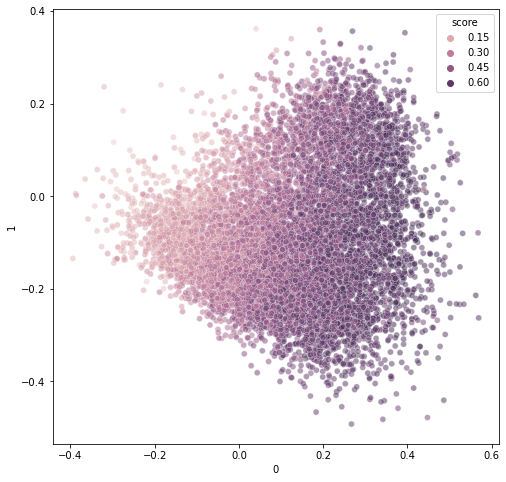

In [161]:
import seaborn as sns
coords = pd.DataFrame(all_reduced, index=vocab_include_list)
coords['score'] = pd.Series(scores)
labels = ['Low', 'High']
coords['cat'] = pd.qcut(coords.score, len(labels), labels=labels).astype("string")
small = coords.dropna().iloc[::1]
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=small[0], y=small[1], hue=small['score'], legend='brief', alpha=.5)

Compare low and high intersect words.

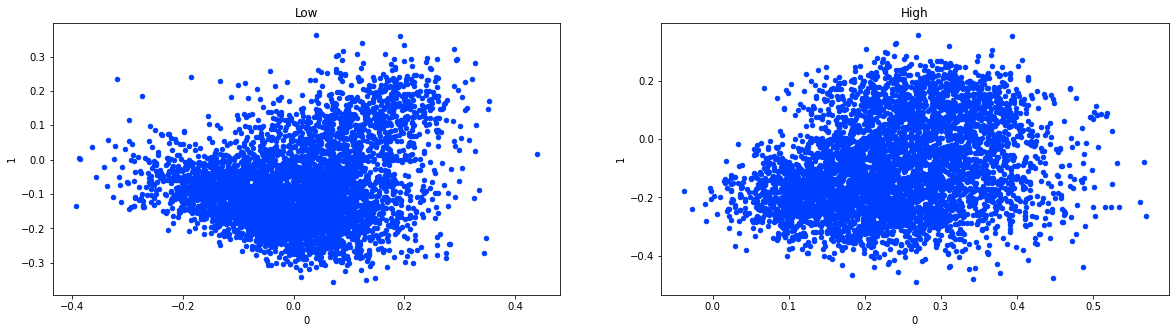

In [162]:
fig, axs = plt.subplots(ncols=len(labels), figsize=(20,5))
for cat,ax in zip(labels, axs):
    coords[coords.cat == cat].plot(kind='scatter', x=0,y=1, ax=ax, title=cat)

### Plotting difference in use of 'cool'

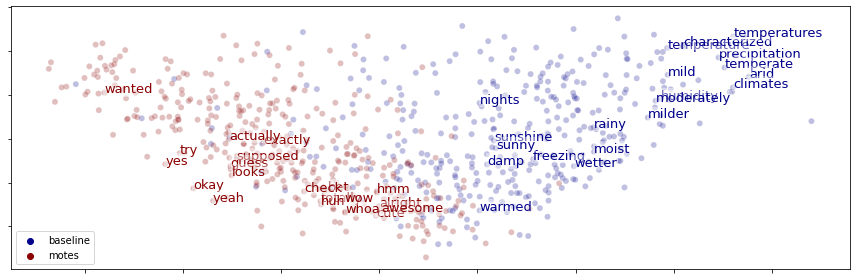

In [214]:
q = 'cool' #sorted_scores.head(400).sample().index[0]
fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=False)
fig.tight_layout()

q_vec = mc.target.get_vector(q)
q_coord = pca.transform([q_vec])[0]

all_words = mc.compare_nns(q, 500)
vecs = np.vstack([mc.target.get_vector(word) for word in all_words['general']+all_words['child']+all_words['overlap']]) 

#pca_coords = pca.transform(vecs)
pca_coords = PCA(n_components=2).fit_transform(vecs)

coords = pd.DataFrame(pca_coords, index=all_words['general']+all_words['child']+all_words['overlap'])
coords['model'] = ['baseline']*len(all_words['general']) + ['motes']*len(all_words['child']) + ['both']*len(all_words['overlap'])
coords['rank'] = list(range(0, len(all_words['general']))) + list(range(0, len(all_words['child']))) + list(range(0, len(all_words['overlap'])))

coords = coords.query('model != "both"')

sns.scatterplot(x=coords[0], y=coords[1], hue=coords['model'],
                palette=['darkblue', 'darkred'],
                legend=True, alpha=.25, ax=ax)
#for word, data in coords.query('model=="baseline"').sample(10).iterrows():
# sorting by rank ensures that higher ranks are drawn over lower ranks
for word, data in coords.query('rank < 20').sort_values('rank', ascending=False).iterrows():
    if data['model'] == 'baseline':
        c = 'darkblue'
    elif data['model'] == 'motes':
        c = 'darkred'
    else:
        c = 'darkgoldenrod'
    ax.text(data[0], data[1], word, color=c, fontsize=13, alpha=1, bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.4))
ax.set_xlabel('') #"Related words for: " + q)
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()
plt.legend(loc='lower left')
plt.savefig('fig1-example.pdf', dpi=100)

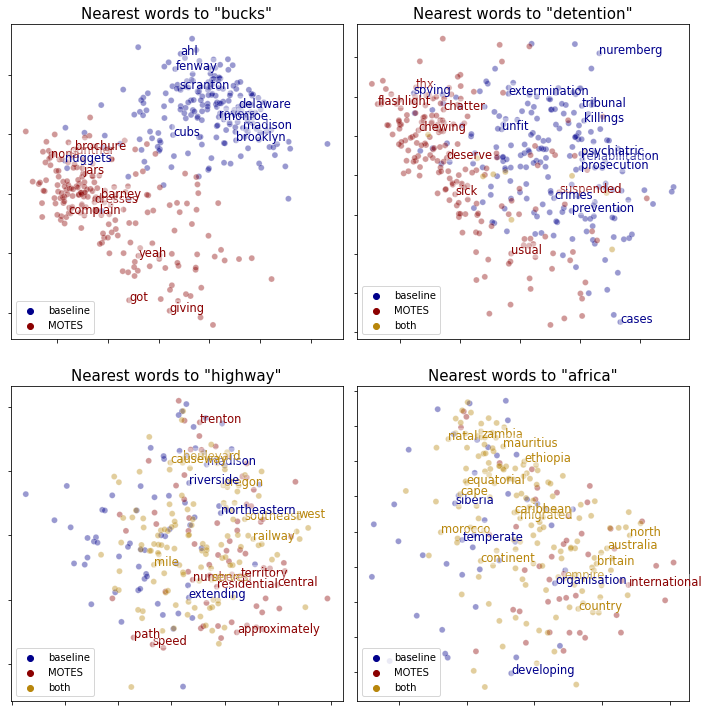

In [282]:
qs = ['bucks', 'detention', 'highway', 'africa']
fig, axs = plt.subplots(2, len(qs)//2, figsize=(5*len(qs)//2, 5*2), sharey=False)
axs = np.hstack([axs[0], axs[1]])
fig.tight_layout()

motesname = 'MOTES'

for q, ax in zip(qs, axs):
    q_vec = mc.target.get_vector(q)
    q_coord = pca.transform([q_vec])[0]

    all_words = mc.compare_nns(q, 200)
    vecs = np.vstack([mc.target.get_vector(word) for word in all_words['general']+all_words['child']+all_words['overlap']]) 

    pca_coords = pca.transform(vecs)
    coords = pd.DataFrame(pca_coords, index=all_words['general']+all_words['child']+all_words['overlap'])
    coords['model'] = ['baseline']*len(all_words['general']) + [motesname]*len(all_words['child']) + ['both']*len(all_words['overlap'])
    
    palette = coords['model'].replace('baseline', 'darkblue').replace(motesname, 'darkred').replace('both', 'darkgoldenrod')
    
    sns.scatterplot(x=coords[0], y=coords[1], hue=coords['model'],
                    palette=palette.drop_duplicates().tolist(),
                    alpha=.4, ax=ax)
    # a random sample, but with state set to stay consistent
    for word, data in coords.sample(20, random_state=1004).iterrows():
        if data['model'] == 'baseline':
            c = 'darkblue'
        elif data['model'] == motesname:
            c = 'darkred'
        else:
            c = 'darkgoldenrod'
        ax.text(data[0], data[1], word, color=c, fontsize=11.5, bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=.3))
    ax.set_title(f"Nearest words to \"{q}\"", fontsize = 15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(loc='lower left')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)
plt.savefig('fig3-nn-examples.pdf', dpi=100)